In [1]:
import pathlib
import sys
sys.path.append("./../")
sys.path.append("/home/kwantics/python3-tasks/mozillaTTS/")
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt

#from utils.fast_speech import DurationCalculator
from TTS.utils.io import load_config
from TTS.utils.text.symbols import make_symbols
from TTS.utils.measures import alignment_diagonal_score
from TTS.utils.generic_utils import setup_model
from TTS.utils.synthesis import text_to_seqvec

In [2]:
config_path = pathlib.Path("/home/kwantics/python3-tasks/mozillaTTS/TriptiCloudForwardGravesAttention/hrs33hop256HindiOnly/config.json")
model_path = pathlib.Path("/home/kwantics/python3-tasks/mozillaTTS/TriptiCloudForwardGravesAttention/hrs33hop256HindiOnly/best_model.pth.tar")

In [3]:
config = load_config(str(config_path))

In [4]:
if 'characters' in config.keys():
    symbols, phonemes = make_symbols(**config.characters)
config.__setattr__("double_decoder_consistency",False)
config.__setattr__("ddc_r",0)
num_chars = len(phonemes) if config.use_phonemes else len(symbols)
num_speakers = 0
model = setup_model(num_chars, num_speakers, config)

> Using model: Tacotron2


In [5]:
pretrained_state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(pretrained_state_dict["model"])
model.decoder.set_r(1)

In [6]:
model.eval()
""

''

In [7]:
def get_duration(attention_weights, inputs, mels):
    attention_weights_np = np.asarray([alignment_frame.cpu().detach().numpy() for alignment_frame in attention_weights])
    token_per_frame = np.argmax(attention_weights_np,axis=1).reshape(1,-1).repeat(attention_weights_np.shape[1],axis=0)
    total_tokens = np.arange(0,attention_weights_np.shape[1]).reshape(-1,1).repeat(attention_weights_np.shape[0],axis=1)
    durations = np.equal(total_tokens, token_per_frame).sum(axis=1).astype(np.float32)

    assert durations.shape == inputs.shape, f"Total inputs tokens shape: {inputs.shape} does not match with predicted alignment shape: {durations.shape}"
    assert durations.sum() == mels.shape[1], f"Total framed predicted: {durations.sum()} does not match with total input mel frames: {mels.shape}"
    return durations

In [8]:
def get_attention_matrix(model, mel):
    query_input = torch.cat((mel, model.decoder.context), -1)
    model.decoder.query, model.decoder.attention_rnn_cell_state = model.decoder.attention_rnn(query_input,
                                                                    (model.decoder.query, model.decoder.attention_rnn_cell_state))
    model.decoder.context = model.decoder.attention(model.decoder.query, model.decoder.inputs, model.decoder.processed_inputs, model.decoder.mask)
    return model.decoder.attention.attention_weights


def get_alignment(model, config, inputs, mels):
    inputs = torch.as_tensor(inputs).unsqueeze(0).long()
    mels   = torch.as_tensor(mels).unsqueeze(1)

    # Get Encoder Outputs
    embedded_inputs = model.embedding(inputs).transpose(1, 2)
    encoder_outputs = model.encoder.inference(embedded_inputs)
    
    # Get Decoder Outputs and alignments
    model.decoder._init_states(encoder_outputs, mask=None)
    model.decoder.attention.init_states(encoder_outputs)
    start_mel = model.decoder.get_go_frame(encoder_outputs).unsqueeze(0)
    mels = torch.cat((start_mel, mels),dim=0)
    mels = model.decoder.prenet(mels)
    alignments = []

    for mel in mels:
        alignments_single = get_attention_matrix(model,mel)
        assert inputs.shape[1] == alignments_single.shape[1],f"Input mismatch between num input tokens: {inputs.shape[1]} and alignment encoder_steps {alignments_single.shape[1]}"
        alignments.append(alignments_single.squeeze(0))
    return alignments[1:]

def find_alignment_file(model:torch.nn.Module, config:dict, meta_data: list, mels_dir:pathlib.Path, dur_dir:pathlib.Path, meta_file_name: str):
    for line in tqdm.tqdm(meta_data, desc=f"{meta_file_name}", ncols=100):
        file_stem, text, speaker = line.split("|")
        dur_filepath = dur_dir / f"{file_stem}.npy"

        if not dur_filepath.exists():
            mels_file = mels_dir / f"{file_stem}.npy"
            mels = np.load(mels_file)

            inputs = text_to_seqvec(text, config)
            alignment_matrix = get_alignment(model, config, inputs, mels.T)
            durations = get_duration(alignment_matrix, inputs, mels)
 
            np.save(dur_filepath, durations)

In [9]:
base_dir = pathlib.Path("/home/kwantics/python3-tasks/mozillaTTS/data/kwanticsMultiSpeaker/triptiMale")
meta_files = ["tripti_male_complete_train_eng2hindi_speaker.csv", "tripti_male_complete_val_eng2hindi_speaker.csv"]
mels_dir = base_dir / "feats/mels"
dur_dir = base_dir / "feats/durs"

for meta_file in meta_files:
    meta_file_path = base_dir / meta_file
    with meta_file_path.open() as m_file:
        data = m_file.read().strip().split("\n")
        alignment_matrix = find_alignment_file(model, config, data, mels_dir, dur_dir, meta_file)

tripti_male_complete_val_eng2hindi_speaker.csv: 100%|█████████████| 128/128 [06:08<00:00,  2.88s/it]


#### Alignment Tests

(array([  0.        ,  16.10526316,  32.21052632,  48.31578947,
         64.42105263,  80.52631579,  96.63157895, 112.73684211,
        128.84210526, 144.94736842, 161.05263158, 177.15789474,
        193.26315789, 209.36842105, 225.47368421, 241.57894737,
        257.68421053, 273.78947368, 289.89473684, 306.        ]),
 <a list of 20 Text major ticklabel objects>)

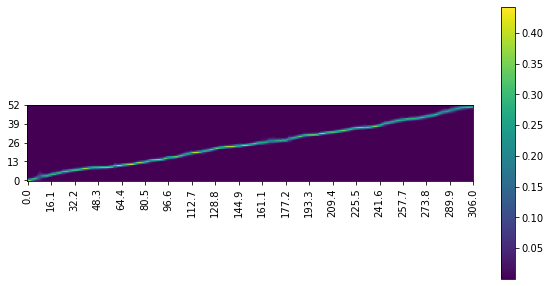

In [161]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)

alignment_image = ax.imshow(alignment_matrix_np.T,origin="bottom left")
fig.colorbar(alignment_image, ax = ax)

ax.set_xticks(np.linspace(0,alignment_matrix_np.T.shape[-1],20))
ax.set_yticks(np.linspace(0,alignment_matrix_np.T.shape[0],5))
plt.xticks(rotation='vertical')